# Unsupervised Representation Learning

You will explore how autoencoders can generate useful representations of data in an unsupervised manner. You will train autoencoders on the MNIST and Frey datasets, visualize what filters the network learns, and test the quality of the learned representation for data compression, generation, and classification.

Your implementation should use the Keras module in Tensorflow 2 (import tensorflow.keras).

# **Part 1: Frey face compression and generation**

## **1.1 Autoencoder setup and training**

Load the Frey dataset and convert the images to have `float32` type and a range of `[-1 1]`. Display some of the images.

Set up an autoencoder, following the example in the linear autoencoder notebook. Unlike the linear autoencoder, your autoencoder should use a multi-layer perceptron for the encoder and decoder and have a two-dimensional latent space. The hidden layers in your encoder and decoder should have some non-linear activation such as ReLU or Leaky ReLU, except the embedding or bottleneck layer (last layer of encoder) which should have a tanh activation. The last layer of the decoder should have size `28*20` and should have linear (None) activation.

The exact design of the encoder and decoder is up to you. For reference, I used a two-layer MLP for the encoder and decoder, and the number of channels was `64-32-2-32-64`.

In [1]:
import numpy as np
import matplotlib as mpl
mpl.rc('image', cmap='gray')
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten, Dense, Reshape, LeakyReLU, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import get_file
from scipy.io import loadmat

### Data Loading and Pre-processing

In [ ]:
path = get_file('frey_rawface.mat','https://www.dropbox.com/scl/fi/m70sh4ef39pvy01czc63r/frey_rawface.mat?rlkey=5v6meiap55z68ada2roxwxuql&dl=1')
data = np.transpose(loadmat(path)['ff'])
# reshape to (num_images, height, width)
images = np.reshape(data,(-1,28,20))

np.random.seed(1234)
np.random.shuffle(images)

print(f"Dataset shape: {images.shape}")
print(f"Pixel value range before scaling: [{np.min(images)}, {np.max(images)}]")

1100584/1100584 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Dataset shape: (1965, 28, 20)
Pixel value range before scaling: [8, 238]


Sample images from the dataset:


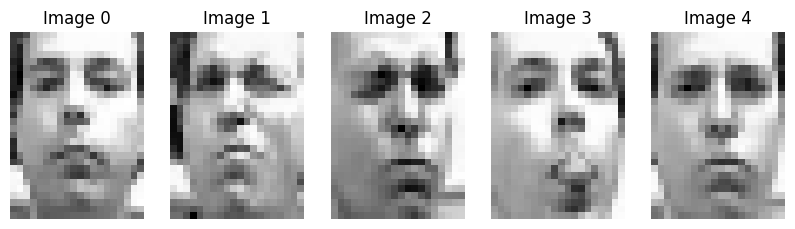

In [ ]:
# display some images
print("Sample images from the dataset:")
plt.figure(figsize=(10, 4))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i])
    plt.title(f"Image {i}")
    plt.axis('off')
plt.show()

In [ ]:
# split data and preprocess
# using the same split ratio as the reference notebook
split_idx = 1800
x_train_orig = images[0:split_idx]
x_test_orig = images[split_idx:]

# convert to float32 and scale to [-1, 1]
x_train = (x_train_orig.astype('float32') / 255.0) * 2.0 - 1.0
x_test = (x_test_orig.astype('float32') / 255.0) * 2.0 - 1.0

img_height, img_width = x_train.shape[1], x_train.shape[2]
img_shape = (img_height, img_width)
flat_img_size = img_height * img_width

print(f"\nTraining data shape: {x_train.shape}")
print(f"Testing data shape: {x_test.shape}")
print(f"Pixel value range after scaling: [{np.min(x_train)}, {np.max(x_train)}]")
print(f"Image shape: {img_shape}")
print(f"Flattened image size: {flat_img_size}")


Training data shape: (1800, 28, 20)
Testing data shape: (165, 28, 20)
Pixel value range after scaling: [-0.9372549057006836, 0.8666666746139526]
Image shape: (28, 20)
Flattened image size: 560


### Building the MLP Autoencoder

In [5]:
# define latent dimension
latent_dim = 2

# define activation for hidden layers
# activation_fn = 'relu'
# using LeakyReLU as suggested alternative
activation_fn = LeakyReLU(alpha=0.2)

# using the suggested architecture 64-32-2-32-64
def build_mlp_encoder(latent_dim, img_shape):
    inputs = Input(shape=img_shape, name='encoder_input')
    flat = Flatten()(inputs)
    x = Dense(64)(flat)
    x = activation_fn(x)
    x = Dense(32)(x)
    x = activation_fn(x)
    # bottleneck layer with tanh activation
    embedding = Dense(latent_dim, activation='tanh', name='encoder_embedding')(x)
    return Model(inputs=inputs, outputs=embedding, name='encoder')

def build_mlp_decoder(latent_dim, flat_img_size, img_shape):
    inputs = Input(shape=(latent_dim,), name='decoder_input')
    x = Dense(32)(inputs)
    x = activation_fn(x)
    x = Dense(64)(x)
    x = activation_fn(x)
    # output layer with linear activation
    reconstruction_flat = Dense(flat_img_size, activation=None, name='decoder_output_flat')(x)
    # reshape back to image dimensions
    reshaped = Reshape(img_shape, name='decoder_output_reshaped')(reconstruction_flat)
    return Model(inputs=inputs, outputs=reshaped, name='decoder')

def build_mlp_autoencoder(encoder, decoder, img_shape):
    inputs = Input(shape=img_shape, name='autoencoder_input')
    embedding = encoder(inputs)
    reconstruction = decoder(embedding)
    return Model(inputs=inputs, outputs=reconstruction, name='autoencoder')

encoder_mlp = build_mlp_encoder(latent_dim, img_shape)
decoder_mlp = build_mlp_decoder(latent_dim, flat_img_size, img_shape)
autoencoder_mlp = build_mlp_autoencoder(encoder_mlp, decoder_mlp, img_shape)

print("Encoder Summary:")
encoder_mlp.summary()
print("\nDecoder Summary:")
decoder_mlp.summary()
print("\nAutoencoder Summary:")
autoencoder_mlp.summary()

Encoder Summary:


/Users/bshowell/Desktop/school/spring 24-25/587/.venv/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 28, 20)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 560)       │          0 │ encoder_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │     35,904 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 64)        │          0 │ dense[0][0],      │
│ (LeakyReLU)         │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ leaky_re_lu[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding   │ (None, 2)         │         66 │ leaky_re_lu[1][0] │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,050 (148.63 KB)

 Trainable params: 38,050 (148.63 KB)

 Non-trainable params: 0 (0.00 B)


Decoder Summary:


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ decoder_input       │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │         96 │ decoder_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 64)        │          0 │ dense_2[0][0],    │
│ (LeakyReLU)         │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      2,112 │ leaky_re_lu[2][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_output_flat │ (None, 560)       │     36,400 │ leaky_re_lu[3][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_output_res… │ (None, 28, 20)    │          0 │ decoder_output_f… │
│ (Reshape)           │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,608 (150.81 KB)

 Trainable params: 38,608 (150.81 KB)

 Non-trainable params: 0 (0.00 B)


Autoencoder Summary:


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ autoencoder_input (InputLayer)  │ (None, 28, 20)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 2)              │        38,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 28, 20)         │        38,608 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,658 (299.45 KB)

 Trainable params: 76,658 (299.45 KB)

 Non-trainable params: 0 (0.00 B)

### Compiling and Training the Autoencoder

In [7]:
opt = Adam(learning_rate=3e-4)
autoencoder_mlp.compile(optimizer=opt, loss='mean_squared_error')

# train the autoencoder
batch_size = 64
epochs = 300

print("\nTraining MLP Autoencoder...")
history_mlp = autoencoder_mlp.fit(x_train, x_train,
                                  batch_size=batch_size,
                                  epochs=epochs,
                                  verbose=0,
                                  validation_split=0.1)
print("Training complete.")


Training MLP Autoencoder...
Training complete.


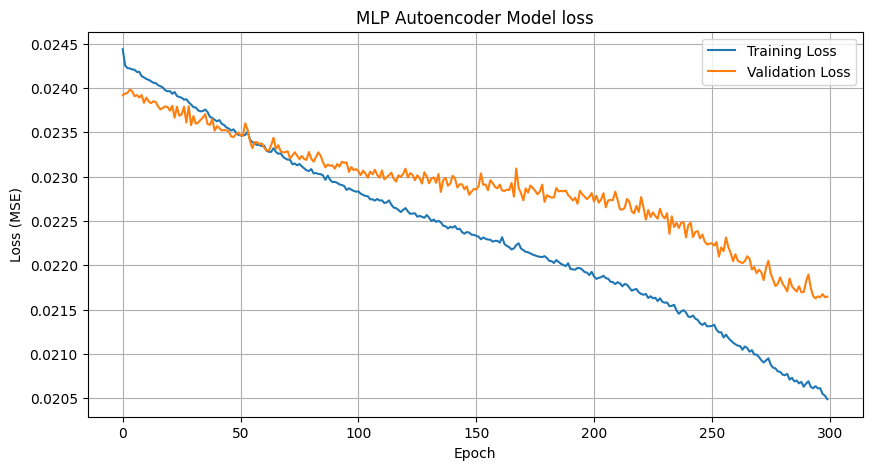

In [8]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history_mlp.history['loss'], label='Training Loss')
plt.plot(history_mlp.history['val_loss'], label='Validation Loss')
plt.title('MLP Autoencoder Model loss')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()